# Tutorial

This tutorial implements the sigmoid nonlinear multivariate Hawkes processes. It includes both simulation and statistical inference. 

## Multivariate Hawkes Processes

The vanilla multivariate Hawkes processes are sequences of timestamps $D=\{\{t_n^i \}_{n=1}^{N_i}\}_{i=1}^M\in[0,T]$ where $t_n^i$ is the timestamp of $n$-th event on $i$-th dimension with $N_i$ being the number of points on $i$-th dimension, $M$ the number of dimensions, $T$ the observation window. The $i$-th dimensional conditional intensity, the probability of an event occurring on $i$-th dimension in $[t,t+dt)$ given all dimensional history before $t$, is designed in a linear superposition form:

$$\lambda_i(t)=\mu_i+\sum_{j=1}^M\sum_{t_n^j<t}\phi_{ij}(t-t_n^j),$$

where $\mu_i>0$ is the baseline rate of $i$-th dimension and $\phi_{ij}(\cdot)\geq0$ is the causal influence function from $j$-th dimension to $i$-th dimension which is normally a parameterized function, e.g., exponential decay. The summation explains the self- and mutual-excitation phenomenon, i.e., the occurrence of previous events increases the intensity of events in the future. Unfortunately, one blemish is the vanilla multivariate Hawkes processes allow only nonnegative (excitatory) influence functions because negative (inhibitory) influence functions may yield a negative intensity which is meaningless.

## Sigmoid Nonlinear Multivariate Hawkes Processes

To reconcile the vanilla version with inhibitory effect and flexible influence function, we propose the SNMHP. Similar to the classic nonlinear multivariate Hawkes processes, the $i$-th dimensional conditional intensity of SNMHP is defined as

$$\lambda_i(t)=\overline{\lambda}_i\sigma(h_i(t)),\ \ \ h_i(t)=\mu_i+\sum_{j=1}^M\sum_{t_n^j<t}\phi_{ij}(t-t_n^j),$$

where $\mu_i$ is the base activation of dimension $i$, $h_i(t)$ is a real-valued activation and $\sigma(\cdot)$ is the logistic (sigmoid) function which maps the activation into a positive real value in $(0,1)$ with $\overline{\lambda}_i$ being a upper-bound to scale it to $(0,\overline{\lambda}_i)$. The sigmoid function is chosen because the P\'{o}lya-Gamma augmentation scheme can be utilized to make the inference tractable.

To achieve a flexible influence function, the influence function is assumed to be a weighted sum of basis functions

$$\phi_{ij}(\cdot)=\sum_{b=1}^B w_{ijb}\tilde{\phi}_b(\cdot),$$

where $\{\tilde{\phi}_b\}_{b=1}^B$ are predefined basis functions and $w_{ijb}$ is the weight capturing the influence from $j$-th dimension to $i$-th dimension by $b$-th basis function with positive indicating excitation and negative indicating inhibition. Although basis functions can be in any form, in order for the weights to represent functional connection strength, basis functions are chosen to be probability densities with compact support that means they have bounded support $[0,T_\phi]$ and the integral is one. As a result, the $i$-th dimensional activation is 

$$h_i(t)=\mu_i+\sum_{j=1}^M\sum_{t_n^j<t}\sum_{b=1}^B w_{ijb}\tilde{\phi}_{b}(t-t_n^j)=\mu_i+\sum_{j=1}^M\sum_{b=1}^B w_{ijb}\sum_{t_n^j<t}\tilde{\phi}_{b}(t-t_n^j)=\mu_i+\sum_{j=1}^M\sum_{b=1}^B w_{ijb}\Phi_{jb}(t)=\mathbf{w}_{i}^T\cdot\mathbf{\Phi}(t),$$

where $\Phi_{jb}(t)$ is the convolution of $j$-th dimensional observation with $b$-th basis function and can be precomputed; $\mathbf{w}_{i}=[\mu_i, w_{i11},\dotsc, w_{iMB}]^T$ and $\mathbf{\Phi}(t)=[1, \Phi_{11}(t), \dotsc, \Phi_{MB}(t)]^T$, both are $(MB+1)\times1$ vectors. Here, the basis functions are scaled (shifted) Beta densities, but alternatives such as Gaussian or Gamma also can be used. 

## A toy example

### Simulation

From the `snm_hawkes_beta` module, we import the `SNMHawkesBeta` class. We set the number of dimensions and basis functions. We initialise an instance of a 2D sigmoid nonlinear multivariate Hawkes processes.

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns # for plot
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False}) # set seaborn style
import matplotlib.pyplot as plt # for plot
from snm_hawkes_beta import SNMHawkesBeta
from scipy.stats import beta

In [26]:
number_of_dimensions=2
number_of_basis=4
toy_model = SNMHawkesBeta(number_of_dimensions,number_of_basis)

We input the parameters: the intensity upperbound $\bar{\lambda}=[5,5]$, the base activation $\mu=[0,0]$, the parameters of basis functions (beta densities) are $\text{Beta}(a=50,b,=50,\text{shift}=\{-2,-1,0,1\})$, the influence weight $W=[[[1,0,0,0],[0,-0.5,0,0]],[[0,0,0,-0.5],[0,0,1,0]]]$ and the support of influence function (the scale of basis functions) $T_\phi=6$.

In [27]:
beta_ab=np.array([[50,50,-2],[50,50,-1],[50,50,0],[50,50,1]])
T_phi=6
lamda_ub=np.array([5,5])
base_activation=np.array([0,0])
weight=np.array([[[1,0,0,0],[0,-0.5,0,0]],[[0,0,0,-0.5],[0,0,1,0]]])

In [28]:
toy_model.set_hawkes_hyperparameters(beta_ab, T_phi)
toy_model.set_hawkes_parameters(lamda_ub, base_activation, weight)

In [29]:
points_hawkes = toy_model.simulation(T=200)
points_hawkes_test = toy_model.simulation(T=200)

### Inference

We use the EM algorithm to perform inference. The input arguments are training data: `points_hawkes`, test data: `points_hawkes_test`, the end time of training data: `T` and test data: `T_test`, the "variance" of the Laplace prior: `b`, the number of Gaussian quadrature nodes `num_gq` on \[0,T\] and `num_gq_test` on \[0,T_test\], the number of EM iterations: `num_iter`. 

In [15]:
lamda_ub_estimated,W_estimated,logL,logL_test = toy_model.EM_inference(points_hawkes, points_hawkes_test,\
                                          T=200, T_test=200, b=0.05, num_gq=1000, num_gq_test=1000, num_iter=100)

The output `lamda_ub_estimated` is the estimated intensity upperbounds, `W_estimated[:,0]` is the estimated base activation, `W_estimated[:,1:]` is the estimated influence weight, `logL` and `logL_test` are the training and test log-likelihood along EM iterations. Now we set the estimated parameters to the instance. 

In [16]:
toy_model.set_hawkes_parameters_estimated(lamda_ub_estimated, W_estimated)

In [17]:
toy_model.lamda_ub_estimated, toy_model.base_activation_estimated,toy_model.weight_estimated

(array([5.26273803, 5.17347912]),
 array([-1.54242507e-55, -3.17254214e-63]),
 array([[ 8.98375459e-001,  5.74303780e-002,  1.28355568e-133,
          2.88111105e-002, -2.72769725e-014, -6.39600318e-001,
          1.28764837e-002,  1.10226123e-008],
        [ 7.41456430e-007, -4.03228010e-078,  2.58729109e-003,
         -4.82776943e-001,  6.83206905e-002, -1.11200283e-001,
          8.87065777e-001,  3.65615668e-130]]))

Now let us visualize the estiamted influence functions.

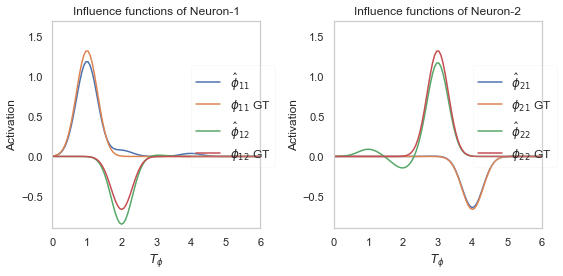

In [18]:
fig=plt.figure(1,figsize=(8,4))

axs=fig.add_subplot(1,2,1)
for j in range(2):
    axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated(0,j,np.linspace(0,T_phi,100)),label='$\hat{\phi}_{1%s}$'%(j+1))
    axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated(0,j,np.linspace(0,T_phi,100),gt=True),label='$\phi_{1%s}$ GT'%(j+1))
plt.legend(ncol=1,loc='center',bbox_to_anchor=(0.87, 0.54),framealpha=0.1,fontsize=12)
plt.xlabel('$T_\phi$',fontsize=12)
plt.ylabel('Activation',fontsize=12)
plt.xlim(0,6)
plt.ylim(-0.9,1.7)
plt.title('Influence functions of Neuron-1',fontsize=12)

axs=fig.add_subplot(1,2,2)
for j in range(2):
    axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated(1,j,np.linspace(0,T_phi,100)),label='$\hat{\phi}_{2%s}$'%(j+1))
    axs.plot(np.linspace(0,T_phi,100),toy_model.influence_function_estimated(1,j,np.linspace(0,T_phi,100),gt=True),label='$\phi_{2%s}$ GT'%(j+1))
plt.legend(ncol=1,loc='center',bbox_to_anchor=(0.87, 0.54),framealpha=0.1,fontsize=12)
plt.xlabel('$T_\phi$',fontsize=12)
plt.ylabel('Activation',fontsize=12)
plt.xlim(0,6)
plt.ylim(-0.9,1.7)
plt.title('Influence functions of Neuron-2',fontsize=12)

plt.tight_layout()
plt.show()

Let us visualize the log-likelihood curves along iterations.

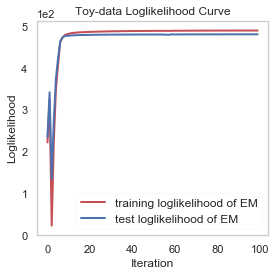

In [19]:
plt.figure(1,figsize=(4,4))
axs=plt.subplot(111)
axs.plot(range(len(logL)),logL,'r-',linewidth=2,label='training loglikelihood of EM')
axs.plot(range(len(logL_test)),logL_test,'b-',linewidth=2,label='test loglikelihood of EM')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Toy-data Loglikelihood Curve',fontsize=12)
plt.legend(framealpha=0.1,fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()

## Synthetic Data

The synthetic data is an 8D neural spike train data. Both the training and test datasets are on $[0,T=1000]$. The basis functions used for simulation are assumed to be known for inference, which are 4 scaled (shifted) Beta densities $\text{Beta}(a=50,b,=50,\text{shift}=\{-2,-1,0,1\})$ with support $[0,T_{\phi}=6]$. The detailed experimental setup can be found in the paper.  

Let us load the synthetic data. 

In [20]:
df=pd.read_csv('./synthetic_data.csv',index_col=0)
points_hawkes=[]
for i in range(8):
    points_hawkes.append(list(df.iloc[i].values[~np.isnan(df.iloc[i].values)]))
df=pd.read_csv('./synthetic_data_test.csv',index_col=0)
points_hawkes_test=[]
for i in range(8):
    points_hawkes_test.append(list(df.iloc[i].values[~np.isnan(df.iloc[i].values)]))

Let us set the number of dimensions and the number of basis functions, initialise an instance, and then set the hyperparameters: the parameters of basis functions and $T_{\phi}$. Run the EM algorithm to estimated the parameters.

In [21]:
number_of_dimensions=8
number_of_basis=4
beta_ab=np.array([[50,50,-2],[50,50,-1],[50,50,0],[50,50,1]])
T_phi=6

syn_model = SNMHawkesBeta(number_of_dimensions, number_of_basis)
syn_model.set_hawkes_hyperparameters(beta_ab, T_phi)

In [23]:
%%time
lamda_ub_syn_esti,W_syn_esti,logL_syn,logL_test_syn = syn_model.EM_inference(points_hawkes, points_hawkes_test,\
                                          T=1000, T_test=1000, b=0.05,num_gq=2000,num_gq_test=2000,num_iter=200) # it runs 27min on my laptop

Wall time: 26min 50s


Set the estimated parameters to the instance. 

In [29]:
syn_model.set_hawkes_parameters_estimated(lamda_ub_syn_esti, W_syn_esti)

Let us visualize all the estiamted influence functions.

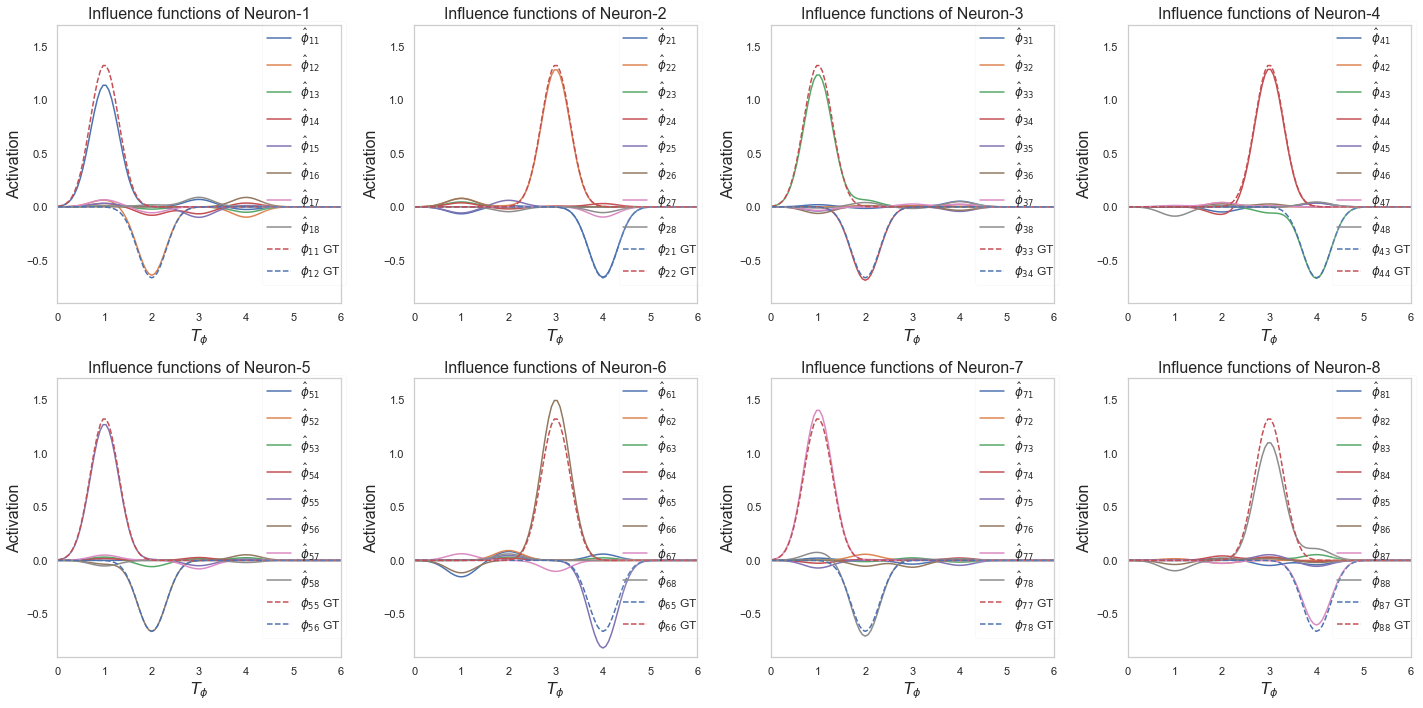

In [30]:
fig=plt.figure(1,figsize=(20,10))
for i in range(0,number_of_dimensions,2):
    axs=fig.add_subplot(2,int(number_of_dimensions/2),i+1)
    for j in range(number_of_dimensions):
        axs.plot(np.linspace(0,T_phi,100),syn_model.influence_function_estimated(i,j,np.linspace(0,T_phi,100)),label='$\hat{\phi}_{%s%s}$'%(i+1,j+1))
    axs.plot(np.linspace(0,T_phi,100),beta.pdf(np.linspace(0,T_phi,100), a=50, b=50, loc=-2, scale=6),'--',color='r',label='$\phi_{%s%s}$ GT'%(i+1,i+1))
    axs.plot(np.linspace(0,T_phi,100),-0.5*beta.pdf(np.linspace(0,T_phi,100), a=50, b=50, loc=-1, scale=6),'--',color='b',label='$\phi_{%s%s}$ GT'%(i+1,i+2))
    plt.legend(ncol=1,loc='center',bbox_to_anchor=(0.87, 0.54),framealpha=0.1,fontsize=12)
    plt.xlabel('$T_\phi$',fontsize=16)
    plt.ylabel('Activation',fontsize=16)
    plt.xlim(0,6)
    plt.ylim(-0.9,1.7)
    plt.title('Influence functions of Neuron-%s'%(i+1),fontsize=16)

    axs=fig.add_subplot(2,int(number_of_dimensions/2),i+2)
    for j in range(number_of_dimensions):
        axs.plot(np.linspace(0,T_phi,100),syn_model.influence_function_estimated(i+1,j,np.linspace(0,T_phi,100)),label='$\hat{\phi}_{%s%s}$'%(i+2,j+1))
    axs.plot(np.linspace(0,T_phi,100),-0.5*beta.pdf(np.linspace(0,T_phi,100), a=50, b=50, loc=1, scale=6),'--',color='b',label='$\phi_{%s%s}$ GT'%(i+2,i+1))
    axs.plot(np.linspace(0,T_phi,100),beta.pdf(np.linspace(0,T_phi,100), a=50, b=50, loc=0, scale=6),'--',color='r',label='$\phi_{%s%s}$ GT'%(i+2,i+2))
    plt.legend(ncol=1,loc='center',bbox_to_anchor=(0.87, 0.54),framealpha=0.1,fontsize=12)
    plt.xlabel('$T_\phi$',fontsize=16)
    plt.ylabel('Activation',fontsize=16)
    plt.xlim(0,6)
    plt.ylim(-0.9,1.7)
    plt.title('Influence functions of Neuron-%s'%(i+2),fontsize=16)
plt.tight_layout()
plt.show()

Let us visualize the log-likelihood curves along iterations.

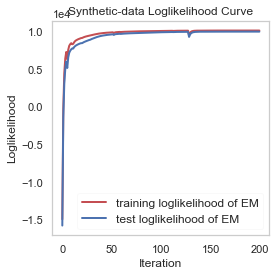

In [33]:
plt.figure(1,figsize=(4,4))
axs=plt.subplot(111)
axs.plot(range(len(logL_syn)),logL_syn,'r-',linewidth=2,label='training loglikelihood of EM')
axs.plot(range(len(logL_test_syn)),logL_test_syn,'b-',linewidth=2,label='test loglikelihood of EM')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.title('Synthetic-data Loglikelihood Curve',fontsize=12)
plt.legend(framealpha=0.1,fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()

Let us visualize the heat map of the functional connectivity

In [36]:
phi_heat=syn_model.heat_map() # this is the estimated heatmap

In [38]:
phi_heat_gt=np.abs(np.array([[1,-0.5,0,0,0,0,0,0],[-0.5,1,0,0,0,0,0,0],[0,0,1,-0.5,0,0,0,0],[0,0,-0.5,1,0,0,0,0],\
                [0,0,0,0,1,-0.5,0,0],[0,0,0,0,-0.5,1,0,0],[0,0,0,0,0,0,1,-0.5],[0,0,0,0,0,0,-0.5,1]])) # this is the ground-truth heatmap

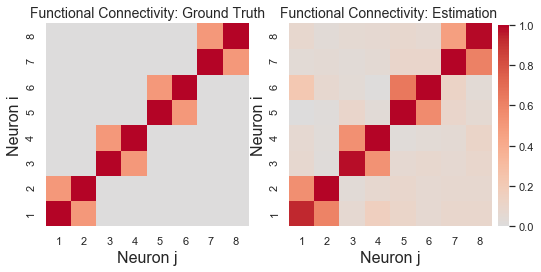

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
cbar_ax = fig.add_axes([.91, 0.15, .02, .7])
sns.heatmap(phi_heat_gt,ax=ax1,center=0,vmin=0,vmax=1,square=True,xticklabels=[1,2,3,4,5,6,7,8],yticklabels=[1,2,3,4,5,6,7,8],cmap='coolwarm',cbar_ax=cbar_ax)
sns.heatmap(phi_heat,ax=ax2, center=0,vmin=0,vmax=1,square=True,xticklabels=[1,2,3,4,5,6,7,8],yticklabels=[1,2,3,4,5,6,7,8],cmap='coolwarm',cbar_ax=cbar_ax)
ax1.set(xticklabels=[1,2,3,4,5,6,7,8],yticklabels=[1,2,3,4,5,6,7,8])
ax2.set(xticklabels=[1,2,3,4,5,6,7,8],yticklabels=[1,2,3,4,5,6,7,8])
ax1.invert_yaxis()
ax2.invert_yaxis()
ax1.set_xlabel('Neuron j',fontsize=12)
ax1.set_ylabel('Neuron i',fontsize=12)
ax2.set_xlabel('Neuron j',fontsize=12)
ax2.set_ylabel('Neuron i',fontsize=12)
ax1.set_title('Functional Connectivity: Ground Truth',fontsize=12)
ax2.set_title('Functional Connectivity: Estimation ', fontsize=12)
plt.show()

## Real Data

In the real data, we analyze our model performance on a real multi-neuron spike train dataset. The spike train dataset contains spike times 
of 25 simultaneously recorded neurons. We extract the spike times in the time window $[0, 300]$ (time unit: 100ms) as the training data and $[300, 600]$ as the test data. The hyperparameters are fine tuned: the scaled (shifted) Beta distribution $\text{Beta}(\tilde{\alpha}=50,\tilde{\beta}=50,\text{shift}=-5)$ with support $[0,T_{\phi}=10]$ is designed as the basis function. More experimental details are given in the paper.  

Let us load the real data. 

In [6]:
points_area17=[]
# read data from spk file
file=['t00','t01','t02','t03','t04','t05','t06','t08','t09','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20','t22','t23','t24','t25','t26','t27']
for f in file:
    with open('./spike_data_area17/'+f+'.spk', mode='rb') as file: 
        points_area17.append(list(np.fromfile(file, dtype=np.int64)/1e5))  # /1e5 to convert to unit of 100ms

In [7]:
# extract the data on [0,300] [300,600] as training and test respectively
T=300
T_test=300
points_real_training=[]
points_real_test=[]
for i in range(len(points_area17)):
    temp=np.array(points_area17[i])
    points_real_training.append(list(temp[temp<T]))
    points_real_test.append(list(temp[(temp>=T) & (temp<T+T_test)]-T))

Let us visualise the extracted training and test data.

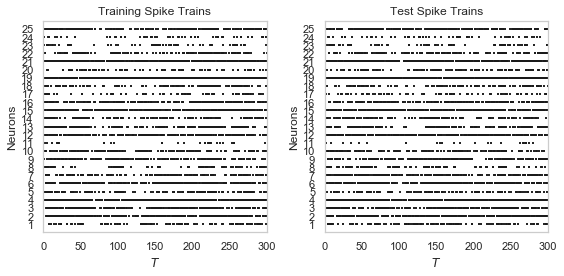

In [18]:
plt.figure(1,figsize=(8,4))
axs=plt.subplot(121)
for i in range(len(points_real_training)):
    axs.scatter(points_real_training[i],np.zeros(len(points_real_training[i]))+i+1, marker=',',s=1,color='k')
axs.set_xlim(0,T)
axs.set_ylim(0,26)
axs.set_yticks(np.arange(1, 26, step=1))
axs.set_xlabel('$T$',fontsize=12)
axs.set_ylabel('Neurons',fontsize=12)
axs.set_title('Training Spike Trains',fontsize=12)

axs=plt.subplot(122)
for i in range(len(points_real_test)):
    axs.scatter(points_real_test[i],np.zeros(len(points_real_test[i]))+i+1, marker=',',s=1,color='k')
axs.set_xlim(0,T)
axs.set_ylim(0,26)
axs.set_yticks(np.arange(1, 26, step=1))
axs.set_xlabel('$T$',fontsize=12)
axs.set_ylabel('Neurons',fontsize=12)
axs.set_title('Test Spike Trains',fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
number_of_dimensions=25
number_of_basis=1
beta_ab=np.array([[50,50,-5]])
T_phi=10

real_model = SNMHawkesBeta(number_of_dimensions, number_of_basis)
real_model.set_hawkes_hyperparameters(beta_ab, T_phi)

In [9]:
%%time
lamda_ub_real_esti,W_real_esti,logL_real,logL_test_real = real_model.EM_inference(points_real_training, points_real_test,\
                    T, T_test, b=0.1, num_gq=1000, num_gq_test=1000, num_iter=100, initial_W=np.load('./initial_W.npy'))
# we fix the initial guess of W to help find the global optimal 

Wall time: 2min 41s


Set the estimated parameters to the instance. 

In [10]:
real_model.set_hawkes_parameters_estimated(lamda_ub_real_esti, W_real_esti)

Let us visualize the log-likelihood curves along iterations.

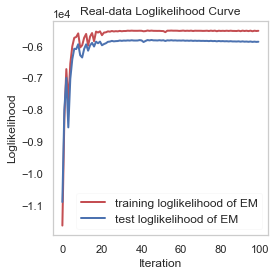

In [19]:
plt.figure(1,figsize=(4,4))
axs=plt.subplot(111)
axs.plot(range(len(logL_real)),logL_real,'r-',linewidth=2,label='training loglikelihood of EM')
axs.plot(range(len(logL_test_real)),logL_test_real,'b-',linewidth=2,label='test loglikelihood of EM')
plt.xlabel('Iteration',fontsize=12)
plt.ylabel('Loglikelihood',fontsize=12)
plt.legend(framealpha=0.1,fontsize=12)
plt.title('Real-data Loglikelihood Curve',fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.tight_layout()
plt.show()

Let us visualise the heatmap of functional connectivity among 25 neurons.

In [20]:
phi_heat_real = real_model.heat_map()

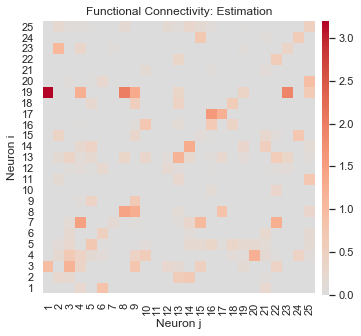

In [23]:
fig, ax1= plt.subplots(1, 1, figsize=(5,5))
cbar_ax = fig.add_axes([0.91, 0.12, .02, .76])
sns.heatmap(phi_heat_real,ax=ax1, center=0,square=True,\
            xticklabels=list(range(1,len(points_real_training)+1)),yticklabels=list(range(1,len(points_real_training)+1)),cmap='coolwarm',cbar_ax=cbar_ax)
ax1.set(xticklabels=list(range(1,len(points_real_training)+1)),yticklabels=list(range(1,len(points_real_training)+1)))
ax1.invert_yaxis()
ax1.set_xlabel('Neuron j',fontsize=12)
ax1.set_ylabel('Neuron i',fontsize=12)
ax1.set_title('Functional Connectivity: Estimation', fontsize=12)
plt.show()

Let us visualise the influence functions between 8-th and 9-th neurons.

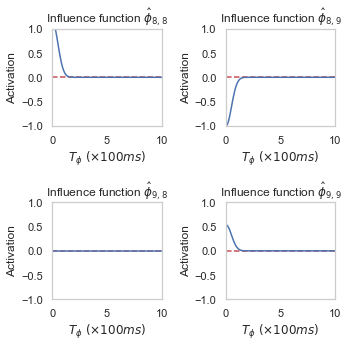

In [24]:
fig=plt.figure(1,figsize=(5,5))
for i in range(4):
    fig.add_subplot(2,2,i+1)
for i in range(7,9):
    for j in range(7,9):
        axs=fig.axes[(i-7)*2+j-7]
        axs.plot([0,T_phi],[0,0],'r--')
        axs.plot(np.linspace(0,T_phi,100),real_model.influence_function_estimated(i,j,np.linspace(0,T_phi,100)),label='$\hat{\phi}_{%s%s}$'%(i+1,j+1))
        axs.set_title('Influence function $\hat{\phi}_{%s,%s}$'%(i+1,j+1),fontsize=12)
        axs.set_xlim(0,T_phi)
        axs.set_ylim(-1,1)
        axs.set_ylabel('Activation',fontsize=12)
        axs.set_xlabel(r'$T_\phi \ (\times100ms)$',fontsize=12)
plt.tight_layout()
plt.show()